
1. Training Q-Learning Agent...


Training: 100%|██████████| 10000000/10000000 [23:56<00:00, 6959.69it/s]


✓ Training completato
  Stati Q-Table: 280
  Win Rate:  0.4029
  Loss Rate: 0.5099
  Draw Rate: 0.0872


/tmp/ipython-input-3841832738.py:165: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('results.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


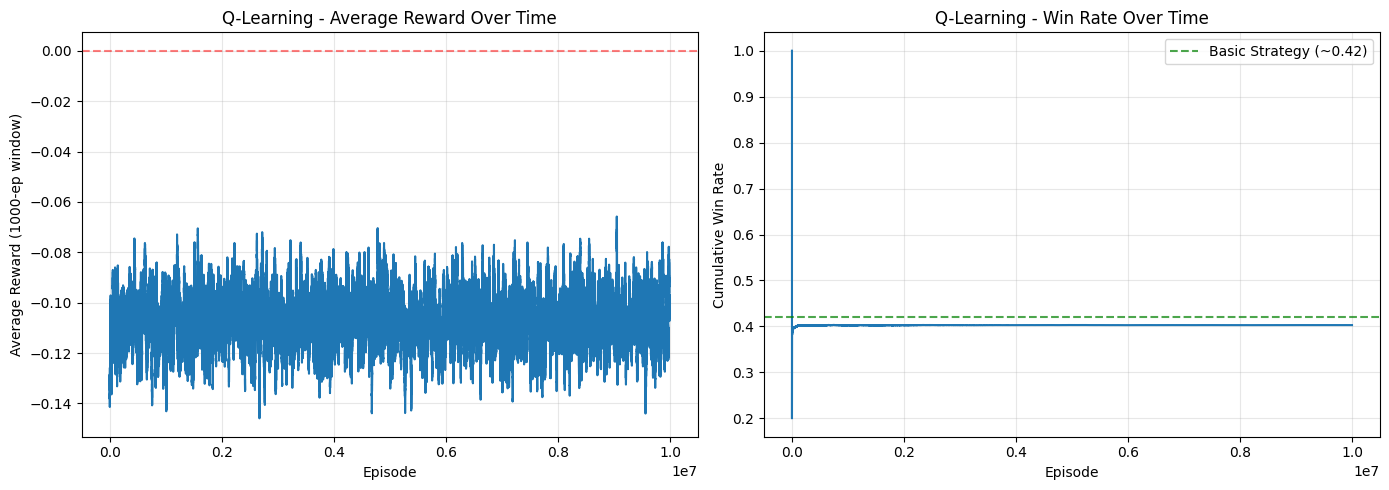


Win Rate: 0.4029
Loss Rate: 0.5099
Draw Rate: 0.0872


In [2]:
# Implementazione Q-Learning Online
from collections import defaultdict
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt


# === BLACKJACK ENVIRONMENT ===
class BlackjackEnv:
    def __init__(self):
        self.deck = self._create_deck()

    def _create_deck(self):
        ranks = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']
        return ranks * 4 * 6  # 6 mazzi

    def _card_value(self, card):
        if card in ['J','Q','K']: return 10
        if card == 'A': return 11
        return int(card)

    def _hand_value(self, hand):
        value = sum(self._card_value(c) for c in hand)
        aces = hand.count('A')
        while value > 21 and aces > 0:
            value -= 10
            aces -= 1
        return value

    def reset(self):
        # FIX: Ricrea il mazzo ad ogni reset
        self.deck = self._create_deck()
        random.shuffle(self.deck)
        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]
        return self._get_state()

    def _get_state(self):
        player_sum = self._hand_value(self.player_hand)
        dealer_up = self._card_value(self.dealer_hand[0])
        usable_ace = 'A' in self.player_hand and player_sum <= 21
        return (player_sum, dealer_up, usable_ace)

    def step(self, action):
        # action: 0=stand, 1=hit
        if action == 1:  # HIT
            # FIX: Controlla se il mazzo è vuoto
            if not self.deck:
                self.deck = self._create_deck()
                random.shuffle(self.deck)

            self.player_hand.append(self.deck.pop())
            player_sum = self._hand_value(self.player_hand)
            if player_sum > 21:
                return self._get_state(), -1, True  # Bust
            return self._get_state(), 0, False

        # STAND - dealer plays
        while self._hand_value(self.dealer_hand) < 17:
            # FIX: Controlla se il mazzo è vuoto
            if not self.deck:
                self.deck = self._create_deck()
                random.shuffle(self.deck)
            self.dealer_hand.append(self.deck.pop())

        player_sum = self._hand_value(self.player_hand)
        dealer_sum = self._hand_value(self.dealer_hand)

        if dealer_sum > 21 or player_sum > dealer_sum:
            reward = 1  # Win
        elif player_sum == dealer_sum:
            reward = 0  # Draw
        else:
            reward = -1  # Loss

        return self._get_state(), reward, True

# === Q-LEARNING AGENT ===
class QLearningAgent:
    def __init__(self, epsilon=0.1, alpha=0.1, gamma=0.9):
        self.Q = defaultdict(lambda: [0.0, 0.0])  # [stand, hit]
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.episode_rewards = []
        self.wins = 0
        self.losses = 0
        self.draws = 0

    def get_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.choice([0, 1])
        return np.argmax(self.Q[state])

    def update(self, state, action, reward, next_state, done):
        current_q = self.Q[state][action]
        if done:
            target = reward
        else:
            target = reward + self.gamma * max(self.Q[next_state])
        self.Q[state][action] = current_q + self.alpha * (target - current_q)

# === TRAINING ===
print("\n1. Training Q-Learning Agent...")

env = BlackjackEnv()
agent = QLearningAgent(epsilon=0.1, alpha=0.1, gamma=0.9)

n_episodes = 10000000
for episode in tqdm(range(n_episodes), desc="Training"):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = agent.get_action(state, training=True)
        next_state, reward, done = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        episode_reward = reward

    agent.episode_rewards.append(episode_reward)
    if episode_reward > 0: agent.wins += 1
    elif episode_reward < 0: agent.losses += 1
    else: agent.draws += 1

print(f"✓ Training completato")
print(f"  Stati Q-Table: {len(agent.Q)}")

win_rate = agent.wins / n_episodes
loss_rate = agent.losses / n_episodes
draw_rate = agent.draws / n_episodes

print(f"  Win Rate:  {win_rate:.4f}")
print(f"  Loss Rate: {loss_rate:.4f}")
print(f"  Draw Rate: {draw_rate:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Learning curve
window = 10000
rewards_smooth = np.convolve(agent.episode_rewards,
                              np.ones(window)/window, mode='valid')
axes[0].plot(rewards_smooth)
axes[0].set_title('Q-Learning - Average Reward Over Time')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Average Reward (1000-ep window)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Win rate
wins_cumulative = np.cumsum([1 if r > 0 else 0 for r in agent.episode_rewards])
episodes = np.arange(1, len(agent.episode_rewards) + 1)
win_rates = wins_cumulative / episodes
axes[1].plot(win_rates)
axes[1].set_title('Q-Learning - Win Rate Over Time')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Cumulative Win Rate')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0.42, color='g', linestyle='--', label='Basic Strategy (~0.42)', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.savefig('results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nWin Rate: {win_rate:.4f}")
print(f"Loss Rate: {loss_rate:.4f}")
print(f"Draw Rate: {draw_rate:.4f}")

algorithm_results = {'agent': agent, 'win_rate': win_rate}
